### Preprocessing for Chen et al., 2024 (PMID: 38981439, GEO: GSE236581)

### Prerequisites

In [ ]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import os
import scvi
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.settings.verbosity = 3            
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

### Tidy up data

In [ ]:
import scipy.io
counts = scipy.io.mmread("../yourpath/GSE236581_counts.mtx").tocsc()
counts = counts.T
barcodes = pd.read_csv("../yourpath/GSE236581_barcodes.tsv", header=None, sep="\t")
features = pd.read_csv("../yourpath/GSE236581_features.tsv", header=None, sep="\t")
metadata = pd.read_csv("../yourpath/GSE236581_CRC-ICB_metadata.txt", delim_whitespace=True)
vdj_data = pd.read_csv("../yourpath/GSE236581_VDJ_merge.txt", delim_whitespace=True)
adata = sc.AnnData(X=counts)
adata.var['gene_ids'] = features[0].values  
adata.var['gene_names'] = features[1].values  
adata.obs['barcodes'] = barcodes[0].values
adata.obs.index = adata.obs['barcodes']
adata.obs = adata.obs.join(metadata)  
adata.obs = adata.obs.join(vdj_data.set_index('cell_name'))  
adata.var.index = adata.var['gene_names']
adata.obs['Full_length(Alpha1)'] = adata.obs['Full_length(Alpha1)'].astype('category')
adata.obs['Full_length(Alpha2)'] = adata.obs['Full_length(Alpha2)'].astype('category')
adata.obs['Full_length(Beta1)'] = adata.obs['Full_length(Beta1)'].astype('category')
adata.obs['Full_length(Beta2)'] = adata.obs['Full_length(Beta2)'].astype('category')
adata.write('../yourpath.h5ad')

### QC

In [ ]:
###Load data
DATA_KEY = '../yourpath.h5ad'
adata = sc.read_h5ad(DATA_KEY)

###functions
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

###QC
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 10) 
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train(accelerator="cpu", devices=1)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train(accelerator="cpu", devices=1)
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df['dif'] = df.doublet - df.singlet
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
adata = sc.read_h5ad(DATA_KEY)
print(f"Total number of cells: {adata.n_obs}")
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata = adata[~adata.obs.doublet]
print(f"Number of cells after filtering of doublets: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 200) 
adata.var['mt'] = adata.var_names.str.startswith('MT-')
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=[20], log1p=True, inplace=True)
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_20_genes", 5))
adata.obs.outlier.value_counts()
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 20)
adata.obs.mt_outlier.value_counts()
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

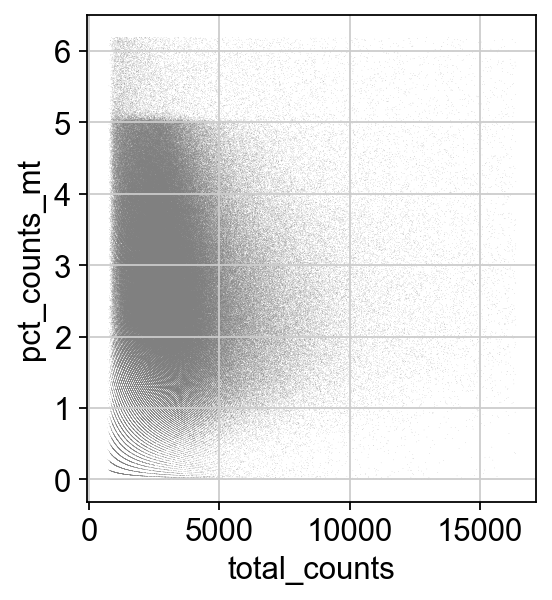

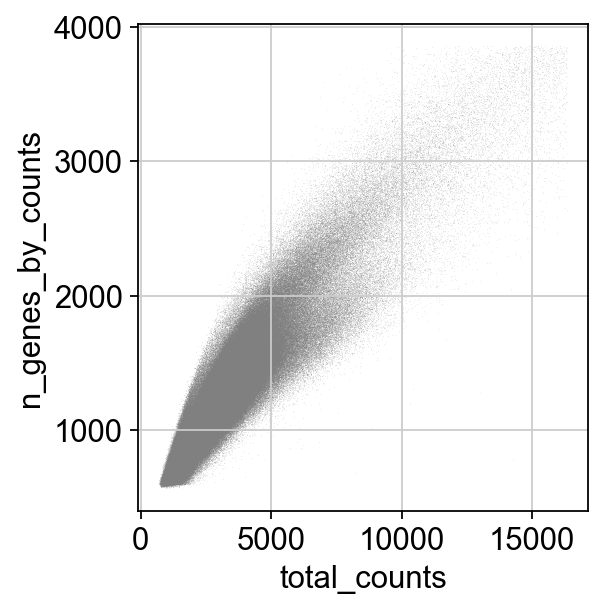

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata.write('../yourpath.h5ad')

### Annotation and metadata

In [ ]:
#Load data
adata = sc.read_h5ad('../yourpath.h5ad')

#Add annotation 1
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=6000, layer="counts", subset=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

scvi.model.SCVI.setup_anndata(adata, layer='counts',
                              batch_key='Patient',
                              continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)
model.train(accelerator="cpu", devices=1)
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)
adata.layers['scVI_normalized'] = model.get_normalized_expression(library_size= 1e4)

In [ ]:
#Add annotation 2
cell_type = {
    '0':'T/NK cells',
    '1': 'T/NK cells',
    '2': 'T/NK cells',
    '3': 'T/NK cells',
    '4': 'T/NK cells',
    '5': 'B cells',
    '6': 'T/NK cells',
    '7': 'B cells',
    '8': 'T/NK cells',
    '9': 'Myeloid cells',
    '10': 'T/NK cells',
    '11': 'B cells',
    '12': 'Epithelial cells',
    '13': 'T/NK cells',
    '14': 'Stromal cells',
    '15': 'Myeloid cells',
    '16': 'T/NK cells',
    '17': 'B cells',
    '18': 'Myeloid cells',
    '19': 'T/NK cells',
    '20': 'T/NK cells',
    '21': 'Myeloid cells',
    '22': 'Epithelial cells',
    '23': 'T/NK cells',
    '24': 'B cells',
    '25': 'Stromal cells',
    '26': 'Stromal cells',
    '27': 'Stromal cells',
    '28': 'T/NK cells',
    '29': 'Myeloid cells',
    '30': 'B cells',
    '31': 'Myeloid cells',
    '32': 'Stromal cells',
    '33': 'T/NK cells',
    '34': 'T/NK cells',
    '35': 'Epithelial cells',
}

adata.obs['anno'] = adata.obs.leiden.map(cell_type)
adata_anno = adata.obs['anno']
bdata = sc.read_h5ad(filename='../yourpath.h5ad')
bdata.obs['anno'] = adata_anno
bdata.obs['anno2'] = adata.obs['anno']

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:05)


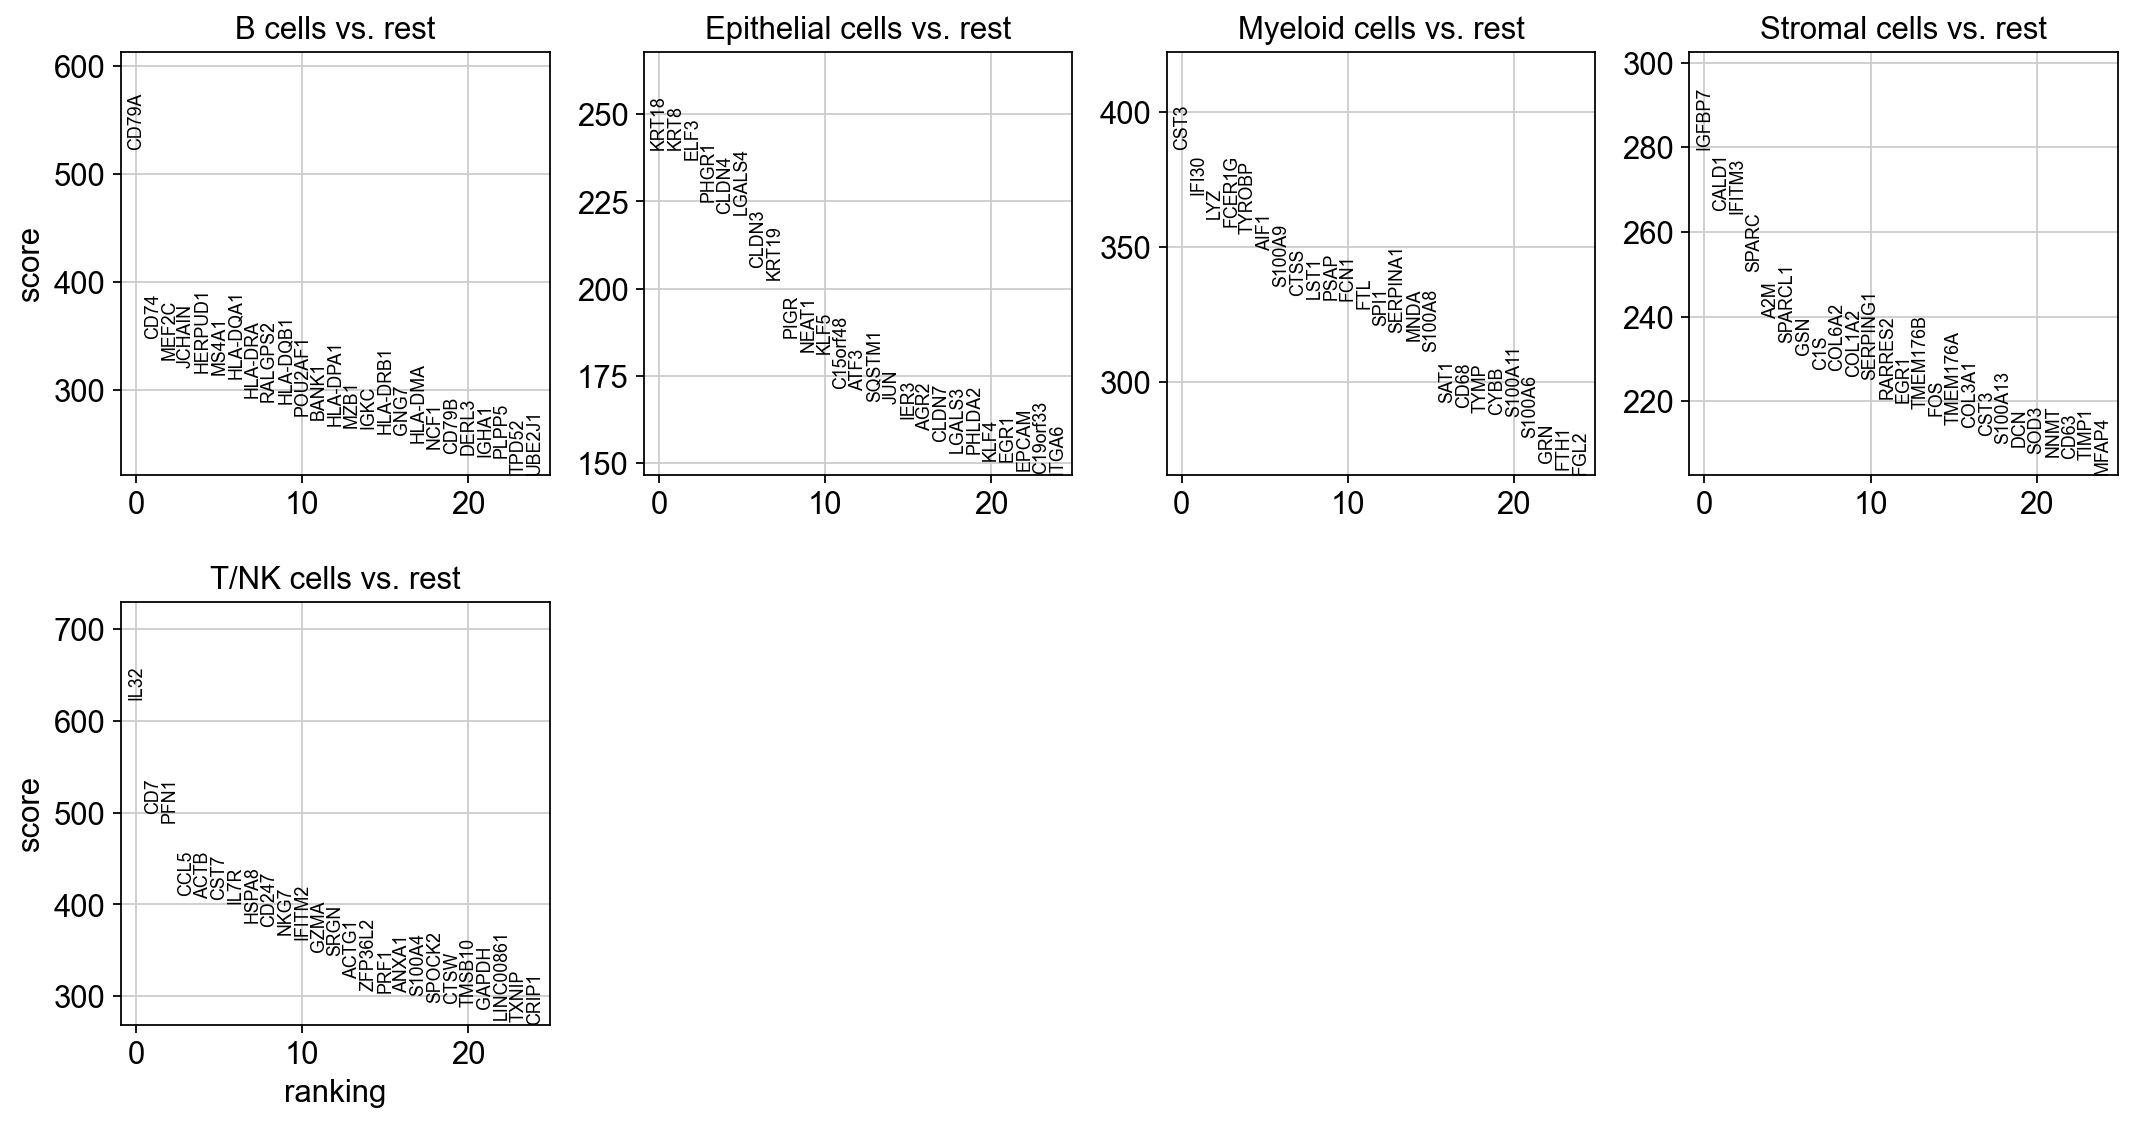

In [16]:
sc.tl.rank_genes_groups(adata, 'anno', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
#Add metadata
bdata.obs['sample'] = bdata.obs['Patient']
bdata.obs['tissue'] = bdata.obs['Tissue']
metadata = pd.read_excel('../yourpath/mmc2-2.xlsx', sheet_name='scRNA-seq patient meta', header=1)
metadata['Patient'] = metadata['Patient ID']
merged_df = bdata.obs.merge(metadata, how="left", on="Patient")
bdata.obs = merged_df
bdata.obs.index = adata.obs.index
bdata.obsm['X_scVI'] = adata.obsm['X_scVI']
bdata.write('../yourpath.h5ad')